# 📑 &nbsp; Deep Learning. Breed Recognition
<a href="https://olgabelitskaya.github.io/README.html">&#x1F300; &nbsp; 
Home Page &nbsp;</a> &nbsp; &nbsp; &nbsp;
<a href="https://www.instagram.com/olga.belitskaya/">&#x1F300; &nbsp;
Instagram Posts &nbsp;</a> &nbsp; &nbsp; &nbsp;
<a href="https://www.pinterest.ru/olga_belitskaya/code-style/">&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have created the dataset of <br/>
about 500 color images (160x160x3) with horse breeds.<br/>
## ✒️ &nbsp; Importing Libraries and Defining Helpful Functions

In [3]:
!pip install --upgrade neural_structured_learning --user

Requirement already up-to-date: neural_structured_learning in /root/.local/lib/python3.6/site-packages (1.3.1)


In [4]:
spath='/usr/local/lib/python3.6/dist-packages'
import sys; sys.path.append(spath)
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,torch,zipfile,os
import tensorflow as tf,pylab as pl
import pandas as pd,numpy as np
import tensorflow_hub as th
import tensorflow.image as timage
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.models import Sequential
import neural_structured_learning as nsl
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
from IPython.core.magic import register_line_magic

 ## ✒️ &nbsp; Data Loading and Preprocessing

In [5]:
fpath='https://olgabelitskaya.github.io/'
zf='HorseBreedImages.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)

['test_images', 'test_labels', 'train_images', 'train_labels']


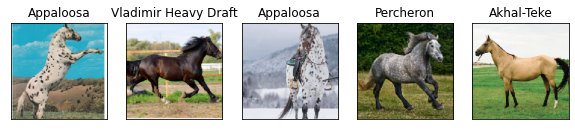

In [6]:
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron',
       'Arabian','Friesian']
num_classes=len(names)
x_test=np.array(f[keys[0]])
y_test=np.array(f[keys[1]],dtype=np.int32)
x_train=np.array(f[keys[2]])
y_train=np.array(f[keys[3]],dtype=np.int32)
fig=pl.figure(figsize=(10,4))
n=np.random.randint(1,50)
for i in range(n,n+5):
    ax=fig.add_subplot(1,5,i-n+1,\
    xticks=[],yticks=[],
    title=names[int(y_test[i])])
    ax.imshow((x_test[i]))

In [7]:
img_size=x_train.shape[2]
n=int(len(x_test)/2)
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                 [x_train.dtype,x_valid.dtype,x_test.dtype],
                 [y_train.shape,y_valid.shape,y_test.shape],
                 [y_train.dtype,y_valid.dtype,y_test.dtype]],
                 columns=['train','valid','test'],
                 index=["images' shape",'image type',
                        "labels' shape",'label type'])
df

,train,valid,test
images' shape,"(429, 160, 160, 3)","(53, 160, 160, 3)","(54, 160, 160, 3)"
image type,float32,float32,float32
labels' shape,"(429,)","(53,)","(54,)"
label type,int32,int32,int32


In [8]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [9]:
batch_size2=16; img_size2=64
x_train2=timage.resize(x_train,[img_size2,img_size2])
x_train2=np.transpose(x_train2.numpy(),(0,3,1,2))
print(x_train2.mean(),x_train2.std())
x_valid2=timage.resize(x_valid,[img_size2,img_size2])
x_valid2=np.transpose(x_valid2.numpy(),(0,3,1,2))
x_test2=timage.resize(x_test,[img_size2,img_size2])
x_test2=np.transpose(x_test2.numpy(),(0,3,1,2))
random_seed=23
train2=TData(x_train2,y_train)
valid2=TData(x_valid2,y_valid)
test2=TData(x_test2,y_test)
dataloaders={'train':tdl(dataset=train2,shuffle=True, 
                         batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True, 
                         batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True, 
                        batch_size=batch_size2)}

0.49760866 0.26812878


In [10]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break

Image dimensions: torch.Size([16, 3, 64, 64])
Label dimensions: torch.Size([16])


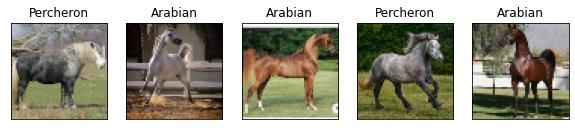

In [11]:
%display_examples valid

## ✒️ &nbsp; Classification Models
### TFHub

In [12]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#aa33ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#aa33ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [13]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=Sequential([
        tkl.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model

In [14]:
handle_base="mobilenet_v2_100_160"
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [15]:
fw='weights.best.hdf5'
early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                 patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(filepath=fw,
                                 save_best_only=True,verbose=2)
lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                   patience=5,factor=.8)
kmodel=premodel(img_size,2048,mhandle,7,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=16,epochs=50,
                   callbacks=[checkpointer,early_stopping,lr_reduction],
                   validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 5,606,704
Trainable params: 5,572,592
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 2.1357 - accuracy: 0.5594
Epoch 00001: val_loss improved from inf to 10.05057, saving model to weights.best.hdf5
27/27 [==============================] - 3s 113ms/step - loss: 2.1357 - accuracy: 0.5594 - val_loss: 10.0506 - val_accuracy: 0.2642
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.1208 - accuracy: 0.7133
Epoch 00002: val_loss improved from 10.05057 to 4.33704, saving model to weights.best.hdf5
27/27 [==============================] - 2s 73ms/step - loss: 1.1208 - accuracy: 0.7133 - val_loss: 4.3370 - val_accuracy: 0.5094
Epoch 3/50
26/27 [===========================>..] - ETA: 0s - loss: 1.4189 - accuracy: 0.7668
Epoch 00003: val_loss did not improve from 4.33704
27/27 [==============================] - 2s 59ms/step - loss: 1.4093 - accuracy: 0.7669 - val_loss: 18.1309 - val_accuracy: 0.2264
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.9760 - accuracy: 0.7366
Ep

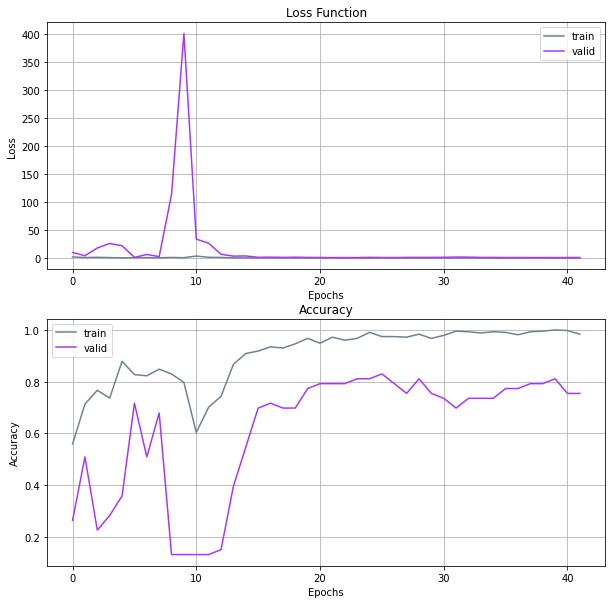

In [16]:
history_plot(history)

In [17]:
kmodel.load_weights(fw)
kmodel.evaluate(x_test,y_test)
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

2/2 [==============================] - 0s 101ms/step - loss: 1.2270 - accuracy: 0.7222


In [18]:
y_test_predict,y_test

(array([2, 0, 2, 6, 0, 6, 2, 2, 2, 6, 5, 3, 2, 2, 4, 2, 1, 6, 6, 0, 0, 4,
        0, 5, 5, 0, 0, 0, 2, 4, 1, 0, 4, 5, 0, 0, 1, 1, 5, 4, 1, 2, 3, 4,
        0, 1, 0, 3, 4, 2, 1, 4, 0, 4]),
 array([5, 0, 2, 6, 0, 3, 2, 5, 2, 6, 5, 3, 0, 2, 4, 6, 1, 6, 6, 0, 0, 4,
        2, 2, 0, 0, 5, 0, 2, 4, 1, 3, 3, 5, 0, 0, 1, 1, 5, 3, 1, 2, 2, 6,
        0, 1, 0, 3, 4, 2, 1, 4, 0, 0], dtype=int32))

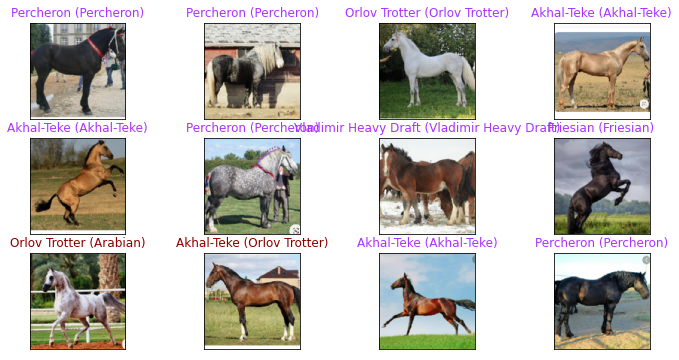

In [19]:
fig=pl.figure(figsize=(12,6))
randch=np.random.choice(x_test.shape[0],
                        size=12,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title("{} ({})".format(names[pred_idx],
                                  names[true_idx]),
                 color=("#aa33ff" if pred_idx==true_idx 
                        else "darkred"))
pl.show()

In [32]:
def kmodel(leaky_alpha):
    model=Sequential()
    model.add(tkl.Conv2D(int(32),(int(5),int(5)),
                         padding='same', 
                         input_shape=x_train.shape[int(1):]))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(int(2),int(2))))
    model.add(tkl.Dropout(float(.25)))
    model.add(tkl.Conv2D(int(196),(int(5),int(5))))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(int(2),int(2))))
    model.add(tkl.Dropout(float(.25)))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(int(1024)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(float(.25)))     
    model.add(tkl.Dense(int(7)))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(float(.01))

In [33]:
fw='weights.best.hdf5'
early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                 patience=int(20),verbose=int(2))
checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=int(2),
                                 save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=int(2),
                                   patience=int(5),factor=float(.8))
history=kmodel.fit(x_train,y_train,epochs=int(70),
                   batch_size=int(16),verbose=int(2),
                   validation_data=(x_valid,y_valid),
                   callbacks=[checkpointer,
                              early_stopping,
                              lr_reduction])

Epoch 1/70

Epoch 00001: val_loss improved from inf to 1.90619, saving model to weights.best.hdf5
27/27 - 1s - loss: 1.9190 - accuracy: 0.1795 - val_loss: 1.9062 - val_accuracy: 0.1321
Epoch 2/70

Epoch 00002: val_loss improved from 1.90619 to 1.80354, saving model to weights.best.hdf5
27/27 - 1s - loss: 1.8446 - accuracy: 0.2541 - val_loss: 1.8035 - val_accuracy: 0.2453
Epoch 3/70

Epoch 00003: val_loss did not improve from 1.80354
27/27 - 1s - loss: 1.7532 - accuracy: 0.2821 - val_loss: 1.9171 - val_accuracy: 0.1509
Epoch 4/70

Epoch 00004: val_loss improved from 1.80354 to 1.71552, saving model to weights.best.hdf5
27/27 - 1s - loss: 1.7186 - accuracy: 0.2960 - val_loss: 1.7155 - val_accuracy: 0.3585
Epoch 5/70

Epoch 00005: val_loss improved from 1.71552 to 1.62360, saving model to weights.best.hdf5
27/27 - 1s - loss: 1.6248 - accuracy: 0.3846 - val_loss: 1.6236 - val_accuracy: 0.4528
Epoch 6/70

Epoch 00006: val_loss improved from 1.62360 to 1.61841, saving model to weights.best.h

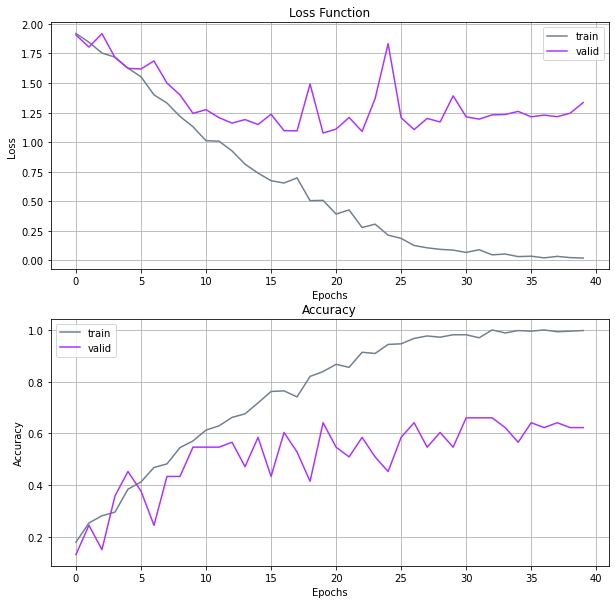

In [34]:
history_plot(history)

In [35]:
kmodel.load_weights(fw)
kmodel.evaluate(x_test,y_test)
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

2/2 [==============================] - 0s 12ms/step - loss: 1.2619 - accuracy: 0.5741


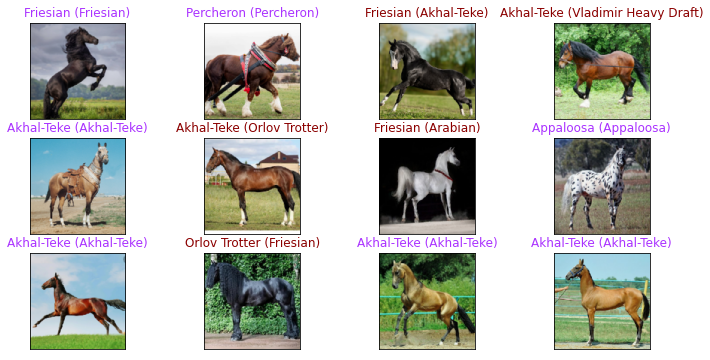

In [37]:
fig=pl.figure(figsize=(12,6))
randch=np.random.choice(x_test.shape[0],
                        size=12,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title("{} ({})".format(names[pred_idx],
                                  names[true_idx]),
                 color=("#aa33ff" if pred_idx==true_idx 
                        else "darkred"))
pl.show()

### PyTorch Models

In [25]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [27]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [28]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [29]:
%train_run 15

Epoch: 001/015 | Batch: 000/027 | Cost: 1.8392
Epoch: 001/015 | Batch: 010/027 | Cost: 2.1439
Epoch: 001/015 | Batch: 020/027 | Cost: 2.8449
Epoch: 001/015
train acc/loss: 62.94%/1.06 valid acc/loss: 62.26%/1.22
Epoch: 002/015 | Batch: 000/027 | Cost: 1.4941
Epoch: 002/015 | Batch: 010/027 | Cost: 0.9803
Epoch: 002/015 | Batch: 020/027 | Cost: 0.8949
Epoch: 002/015
train acc/loss: 69.00%/0.86 valid acc/loss: 58.49%/1.17
Epoch: 003/015 | Batch: 000/027 | Cost: 1.1300
Epoch: 003/015 | Batch: 010/027 | Cost: 1.3834
Epoch: 003/015 | Batch: 020/027 | Cost: 0.7343
Epoch: 003/015
train acc/loss: 76.46%/0.75 valid acc/loss: 69.81%/0.98
Epoch: 004/015 | Batch: 000/027 | Cost: 0.5756
Epoch: 004/015 | Batch: 010/027 | Cost: 1.4751
Epoch: 004/015 | Batch: 020/027 | Cost: 1.4847
Epoch: 004/015
train acc/loss: 84.38%/0.60 valid acc/loss: 69.81%/0.96
Epoch: 005/015 | Batch: 000/027 | Cost: 1.2996
Epoch: 005/015 | Batch: 010/027 | Cost: 1.2229
Epoch: 005/015 | Batch: 020/027 | Cost: 0.9224
Epoch: 005/

In [30]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 97.67% || test acc: 55.56%


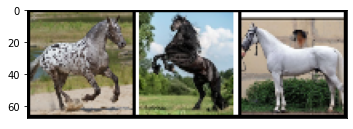


true labels:             Appaloosa            Friesian       Orlov Trotter

predictions:             Appaloosa            Friesian          Akhal-Teke


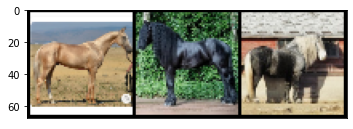


true labels:            Akhal-Teke            Friesian           Percheron

predictions:         Orlov Trotter            Friesian           Appaloosa


In [31]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:3]))
        print('\ntrue labels: ',
              ''.join('%20s'%names[labels[j]] 
                       for j in range(3)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,int(1))
        print('\npredictions: ',
             ''.join('%20s'%names[preds[j]]
                      for j in range(3)))
        if i==1: break